# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/flopy


## 2. Discretization and other inputs

In [60]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
print(ztop.shape)
print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction


## Subsurface properties
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(0.0, 50.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 50.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (23.0, 29.0)  #forced riparian area
rip_cols_forced = (0.0, 50.0)


rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
rech_zone=np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

## Well1: 
pumping1 = 0 #m3/day 
well1_xy= [38000, 29000] #xy location of well 
well1_row = np.floor((nrow)-(well1_xy[1]/dy)) #convert the y location to a row
well1_col=np.floor(well1_xy[0]/dx) #convert the x location to a column
well1_loc = (2,well1_row, well1_col) #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)

#print(well1_col)
#print(well1_row)


## Well2 
#pumping = 0 #m3/day  
#well1_xy= [38000, 29000] #xy location of well 
#well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
#well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
#well1_loc = (2,well1_row,well_col) #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)


## Well3 
#pumping = 0 #m3/day  
#well1_xy= [38000, 29000] #xy location of well 
#well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
#well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
#well1_loc = (2,well1_row,well_col) #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)

wel1 = [0, well1_col, well1_row, pumping1]
wel1_spd = {0: [wel1]}
print(wel1_spd)

## Boundary conditions
h_right = 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

(50, 50)
[125.  124.  123.  122.  121.  120.  119.  118.  117.  116.  115.  114.
 113.  112.  111.  110.  109.  108.  107.  106.  105.  104.  103.  102.
 101.  100.9 100.8 100.7 100.6 100.5 100.4 100.3 100.2 100.1 100.   99.9
  99.8  99.7  99.6  99.5  99.4  99.3  99.2  99.1  99.   98.9  98.8  98.7
  98.6  98.5]
Riparian location(col, row) (0.0, 23.0) (50.0, 29.0)
recharge location(col, row) (0.0, 0.0) (14.0, 50.0)
well1 location(layer, col, row) 38.0 21.0
{0: [[0, 38.0, 21.0, 0]]}


### Layering

In [61]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = K_vert2            #Replace K in the middle layer with the lower value

print(K_horiz)
print(Kz)


10
[[[1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01]
  [1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01]
  [1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01
   1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1.e+01 1

### Boundary/ Initial conditions

In [62]:
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
#ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value

np.set_printoptions(threshold=np.inf)
print(ET_zone.shape)
print(ET_zone)


(1, 50, 50)
[[[0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 1.e-05 1.e-05
   1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
   1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 1.e-05 1.e-05
   1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
   1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]
  [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
   0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 1.e-05 1.e-05
   1.e-05 1.e-05 1.e-05 1.e-05 1.e-05

In [63]:
#create model object
modelname = "Domain_setup"
#moddir="/Applications/MODFLOW/mf2005"
moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel1_spd)


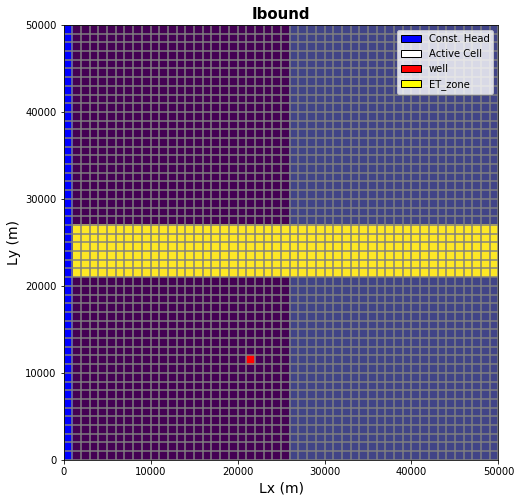

In [64]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
#zones = ET_zone + R_zones
quadmesh = modelmap.plot_array(ET_zone)
#quadmesh = modelmap.plot_array(R_zones) #, color='purple')
quadmesh = modelmap.plot_bc('WEL')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   #mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')